<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/overview_Jan9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
import glob
import random
from PIL import Image
from torch.utils.data import Dataset,random_split
from datasets import Dataset, DatasetDict
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
model_name="places-xlstm-1"

from google.colab import drive
drive.mount('/content/drive')

import os

CHECKPOINTS_DIR = '/content/drive/MyDrive/ckpts'

def save_checkpoint(model, optimizer, epoch):
    os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
    checkpoint_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"ckpt saved for {model_name} at epoch {epoch}.")

def load_checkpoint(model, optimizer):
    ckpt_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    if not os.path.exists(ckpt_path):
        print(f"no ckpt found for {model_name} starting from epoch 0.")
        return 0

    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"ckpt loaded for {model_name} from {ckpt_path}. resuming from epoch {start_epoch}.")

    return start_epoch

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mittalshubham/images256")

print("Path to dataset files:", path)

file_list = random.sample(glob.glob(os.path.join(path, '**', '*.jpg'), recursive=True),30000)

Path to dataset files: /root/.cache/kagglehub/datasets/mittalshubham/images256/versions/10


In [10]:
print("First 5 elements of file_list:", file_list[:5])


First 5 elements of file_list: ['/root/.cache/kagglehub/datasets/mittalshubham/images256/versions/10/b/boat_deck/gsun_1538b33ede57e79617e43a3bcedba193.jpg', '/root/.cache/kagglehub/datasets/mittalshubham/images256/versions/10/s/ski_slope/gsun_36d46340c48668fa9edb6322434a80f6.jpg', '/root/.cache/kagglehub/datasets/mittalshubham/images256/versions/10/v/veranda/gsun_bdc9b99035475abd0e9ddb9ff6aa8519.jpg', '/root/.cache/kagglehub/datasets/mittalshubham/images256/versions/10/m/marsh/gsun_62ecf37bc49deb7723b1e9a2f6f68de3.jpg', '/root/.cache/kagglehub/datasets/mittalshubham/images256/versions/10/p/pavilion/gsun_a20ff48f20f425c6e625babc59810662.jpg']


In [9]:
print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/mittalshubham/images256/versions/10


In [11]:
print("Length of file_list before removal:",len(file_list))


Length of file_list before removal: 30000


In [12]:
target_file = f'{path}/c/cottage_garden/gsun_6c03ae81ab181303144ed2bda2757c89.jpg'


In [13]:
print("Path we're trying to remove:", target_file)


Path we're trying to remove: /root/.cache/kagglehub/datasets/mittalshubham/images256/versions/10/c/cottage_garden/gsun_6c03ae81ab181303144ed2bda2757c89.jpg


In [14]:
# Check if the file exists in file_list using a more robust method
if target_file in file_list:
    file_list.remove(target_file)
    print("File removed successfully")
else:
    print(f"Warning: {target_file} not found in file_list.")
print("Length of file_list after removal:",len(file_list))

Length of file_list after removal: 30000


In [15]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB

        if self.transform:
            img = self.transform(img)

        return {'image': img, 'path': img_path}

In [16]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
dataset = CustomImageDataset(file_list, transform=transform)

In [17]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [18]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [19]:
ds = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

In [20]:
image_example = ds['train'][1000]['image']
print(image_example)
print(image_example.shape)

print(image_example)

tensor([[[0.4392, 0.4941, 0.5686,  ..., 0.4353, 0.4824, 0.4235],
         [0.3765, 0.4706, 0.5725,  ..., 0.4941, 0.4667, 0.4471],
         [0.4078, 0.5255, 0.6235,  ..., 0.4667, 0.4510, 0.5255],
         ...,
         [0.4667, 0.4196, 0.4471,  ..., 0.1451, 0.1490, 0.1647],
         [0.4627, 0.4745, 0.5059,  ..., 0.1608, 0.1686, 0.1529],
         [0.4706, 0.4902, 0.5294,  ..., 0.1569, 0.1843, 0.1843]],

        [[0.4627, 0.4941, 0.5216,  ..., 0.4157, 0.4667, 0.4078],
         [0.3922, 0.4627, 0.5216,  ..., 0.4784, 0.4510, 0.4314],
         [0.4000, 0.5059, 0.5804,  ..., 0.4627, 0.4431, 0.5176],
         ...,
         [0.4039, 0.3569, 0.3804,  ..., 0.1412, 0.1333, 0.1490],
         [0.3765, 0.3882, 0.4235,  ..., 0.1451, 0.1451, 0.1294],
         [0.3765, 0.4000, 0.4392,  ..., 0.1412, 0.1490, 0.1490]],

        [[0.4627, 0.5020, 0.5373,  ..., 0.4000, 0.4549, 0.3961],
         [0.3961, 0.4745, 0.5490,  ..., 0.4667, 0.4392, 0.4275],
         [0.4039, 0.5216, 0.6118,  ..., 0.4549, 0.4471, 0.

In [8]:
file_list.remove(f'{path}/c/cottage_garden/gsun_6c03ae81ab181303144ed2bda2757c89.jpg')

ValueError: list.remove(x): x not in list

In [ ]:


class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB

        if self.transform:
            img = self.transform(img)

        return {'image': img, 'path': img_path}


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
dataset = CustomImageDataset(file_list, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

ds = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}


In [ ]:
image_example = ds['train'][1000]['image']
print(image_example)
print(image_example.shape)

tensor([[[0.1882, 0.1882, 0.1882,  ..., 0.2196, 0.2157, 0.2078],
         [0.2000, 0.2000, 0.2078,  ..., 0.2039, 0.2039, 0.1922],
         [0.1882, 0.1922, 0.2000,  ..., 0.1961, 0.2039, 0.1882],
         ...,
         [0.2314, 0.2000, 0.2078,  ..., 0.2392, 0.2196, 0.1647],
         [0.2078, 0.2235, 0.1843,  ..., 0.2157, 0.2157, 0.1922],
         [0.0824, 0.2000, 0.3137,  ..., 0.2039, 0.1686, 0.1765]],

        [[0.2235, 0.2235, 0.2196,  ..., 0.2078, 0.2039, 0.2000],
         [0.2353, 0.2353, 0.2392,  ..., 0.1922, 0.1922, 0.1843],
         [0.2196, 0.2235, 0.2314,  ..., 0.1961, 0.1922, 0.1765],
         ...,
         [0.2314, 0.2039, 0.2039,  ..., 0.2353, 0.2118, 0.1569],
         [0.2196, 0.2353, 0.1882,  ..., 0.2196, 0.2196, 0.1961],
         [0.0980, 0.2118, 0.3176,  ..., 0.2157, 0.1725, 0.1804]],

        [[0.0157, 0.0157, 0.0196,  ..., 0.0706, 0.0667, 0.0510],
         [0.0275, 0.0275, 0.0392,  ..., 0.0549, 0.0549, 0.0353],
         [0.0196, 0.0235, 0.0392,  ..., 0.0549, 0.0549, 0.

In [ ]:
print(image_example)

In [ ]:
!nvidia-smi

In [ ]:
sample_image = ds['train'][0]['image']
# print(Image.open)
print(f"Sample image shape: {sample_image}")

Sample image shape: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7B319EA5D8A0>


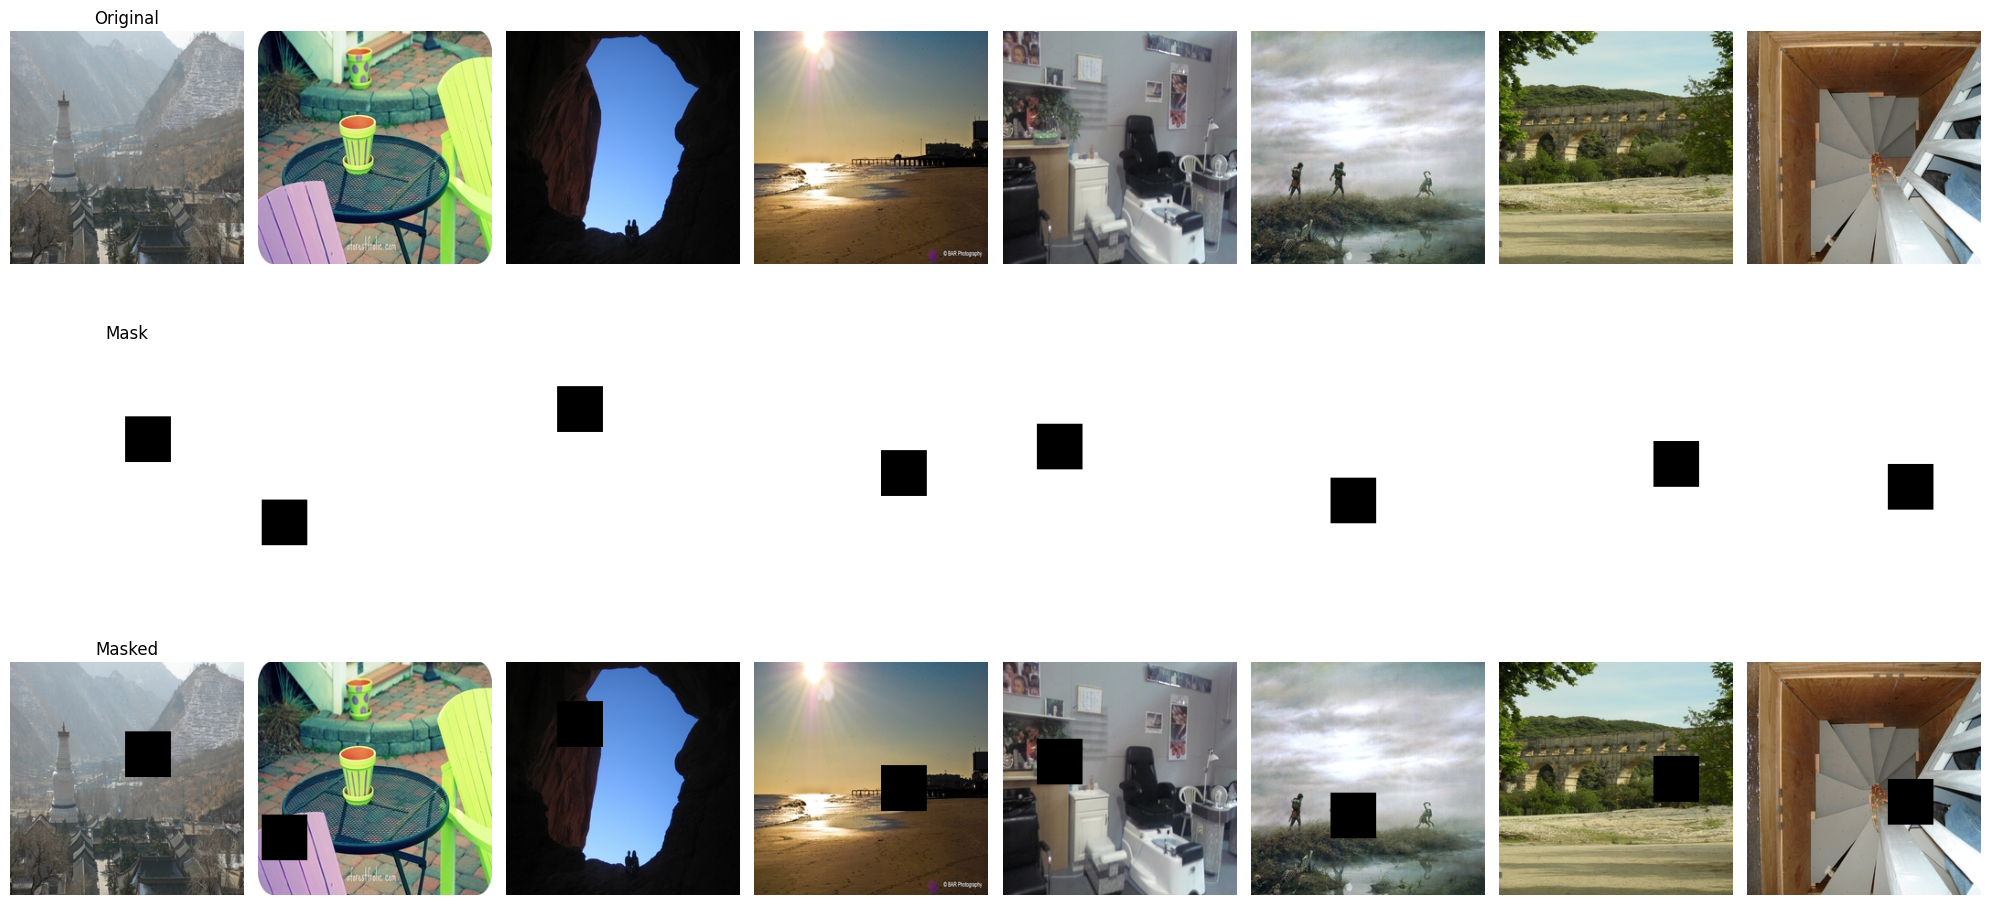

In [ ]:
def create_mask(image, mask_size=50):
    """Create a random square mask for image inpainting"""
    _, h, w = image.shape
    top = np.random.randint(0, h - mask_size)
    left = np.random.randint(0, w - mask_size)
    mask = torch.ones_like(image)
    mask[:, top:top+mask_size, left:left+mask_size] = 0
    return mask

def apply_mask(image, mask):
    """Apply the mask to the image"""
    return image * mask

def visualize_batch(dataloader, num_images=8):
    batch = next(iter(dataloader))

    images = batch['image'][:num_images]

    masks = [create_mask(img) for img in images]
    masked_images = [apply_mask(img, mask) for img, mask in zip(images, masks)]

    # Create a figure with three rows: original images, masks, and masked images
    fig, axes = plt.subplots(3, num_images, figsize=(20, 10))

    for i in range(num_images):
        # Original image
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')

        # Mask
        axes[1, i].imshow(masks[i].permute(1, 2, 0), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Mask')

        # Masked image
        axes[2, i].imshow(masked_images[i].permute(1, 2, 0))
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('Masked')

    plt.tight_layout()
    plt.show()

visualize_batch(train_loader)